# Домашняя работа №6
*Екатерина Драгомирова*

In [55]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import r2_score
from sklearn import model_selection

### Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

#### При увеличении числа деревьев в лесу, ошибка перестает изменяться после достижения своего предельного минимума. Но при увеличении глубины деревьев после достижения минимума ошибка на тесте начинает расти.

In [56]:
X, y = load_breast_cancer(return_X_y=True)
X.shape, y.shape

((569, 30), (569,))

In [57]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=32)

In [58]:
# Реализуем функцию подсчета ошибки
def get_error(pred, y):
    return sum(pred != y) / len(y)

In [59]:
def adaboost(X, y, N, depth):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса объектов
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=depth)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        error = get_error(predictions, y)
        
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if error >= 1 - 1/n_classes: 
            continue

        # Обработаем граничные значения ошибок
        if error == 0:
            error += 1e-10
   
        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - error) / error)


        # Найдем индексы правильно классифицированных элементов
        wrong_mask = predictions != y

        # Увеличим веса для неправильно классифицированных элементов
        w[wrong_mask] *= np.exp(alpha)
        # Уменьшаем веса для правильно классифицированных элементов
        w[~wrong_mask] *= np.exp(-alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

In [60]:
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

In [61]:
train_errors_trees = []
test_errors_trees = []

for n in range(1, 31):
    depth = 1
    models = adaboost(X_train, y_train, n, depth)
    train_errors_trees.append(get_error(predict(X_train, models), y_train))
    test_errors_trees.append(get_error(predict(X_test, models), y_test))

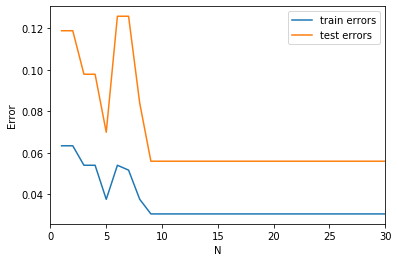

In [62]:
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors_trees, label='train errors')
plt.plot(x, test_errors_trees, label='test errors')
plt.xlabel('N')
plt.ylabel('Error')
plt.legend(loc='upper right');

In [63]:
train_errors_depth = []
test_errors_depth = []

for d in range(1, 11):
    N = 50
    models = adaboost(X_train, y_train, N, d)
    train_errors_depth.append(get_error(predict(X_train, models), y_train))
    test_errors_depth.append(get_error(predict(X_test, models), y_test))

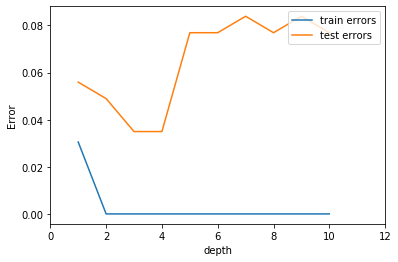

In [64]:
x = list(range(1, 11))

plt.xlim(0, 12)
plt.plot(x, train_errors_depth, label='train errors')
plt.plot(x, test_errors_depth, label='test errors')
plt.xlabel('depth')
plt.ylabel('Error')
plt.legend(loc='upper right');